<a href="https://colab.research.google.com/github/Airukua/NMR-tensorflow/blob/main/NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "tensorflow-text>=2.10"
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text
import csv
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path= '/content/drive/MyDrive/NKORPUS_5.xlsx'

In [ ]:
df = pd.read_excel(path,header=None)

In [ ]:
len(df)

3538

In [ ]:
col1 = df.iloc[:, 0]
col2 = df.iloc[:, 1]

In [ ]:
x=len(col1)
y=len(col2)

In [ ]:
input = col1.tolist()
output = col2.tolist()

In [ ]:
context_raw= np.array(input)
target_raw= np.array(output)

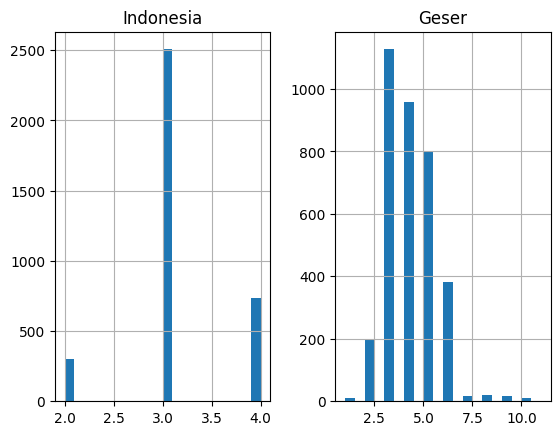

In [ ]:

# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in context_raw:
      eng_len.append(len(i.split()))

for i in target_raw:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'Indonesia':eng_len, 'Geser':fren_len})

length_df.hist(bins = 20)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Bagi data menjadi training set dan validation + test set
context_train, context_val_test, target_train, target_val_test = train_test_split(
    context_raw, target_raw, test_size=0.4, random_state=101)

# Bagi validation + test set menjadi validation set dan test set
context_val, context_test, target_val, target_test = train_test_split(
    context_val_test, target_val_test, test_size=0.5, random_state=101)

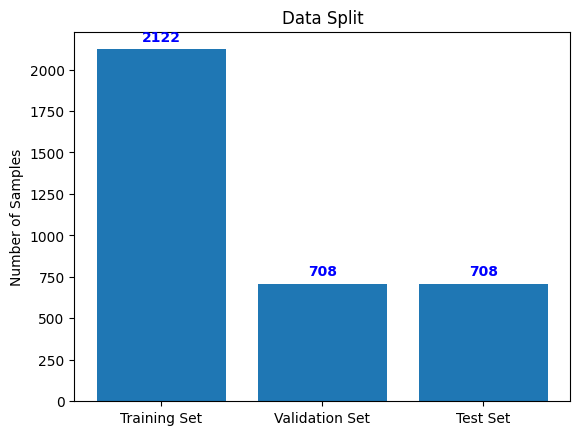

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah sampel dalam masing-masing set
train_count = len(target_train)
val_count = len(target_val)
test_count = len(target_test)

# Buat diagram batang
plt.bar(['Training Set', 'Validation Set', 'Test Set'], [train_count, val_count, test_count])
plt.ylabel('Number of Samples')
plt.title('Data Split')

# Tambahkan label pada bar chart
for i, v in enumerate([train_count, val_count, test_count]):
    plt.text(i, v+50, str(v), color='blue', fontweight='bold', ha='center')

# Tampilkan diagram
plt.show()

In [ ]:
BATCH_SIZE = 32

train_raw = tf.data.Dataset.from_tensor_slices((context_train, target_train)).batch(BATCH_SIZE)
val_raw = tf.data.Dataset.from_tensor_slices((context_val, target_val)).batch(BATCH_SIZE)

In [ ]:
len(val_raw)

23

In [ ]:
# Print some samples from training set
print("Training set:")
for context, target in train_raw.take(2):
    print("Context:", context[:2])
    print("Target:", target[:2])
    print()

# Print some samples from validation set
print("Validation set:")
for context, target in val_raw.take(2):
    print("Context:", context[:2])
    print("Target:", target[:2])
    print()

Training set:
Context: tf.Tensor([b'kalian mengambil tas' b'kalian belajar menjahit'], shape=(2,), dtype=string)
Target: tf.Tensor([b'kumu ma tas' b'kumu balajar firait'], shape=(2,), dtype=string)

Context: tf.Tensor([b'aku merasa kehausan' b'aku belajar menari'], shape=(2,), dtype=string)
Target: tf.Tensor([b'aku rasa mangalan' b'aku balajar sula'], shape=(2,), dtype=string)

Validation set:
Context: tf.Tensor([b'aku menyapu rumah' b'abang tidak mengambil handuk'], shape=(2,), dtype=string)
Target: tf.Tensor([b'aku sirai rumah' b'kaka na handuk tei'], shape=(2,), dtype=string)

Context: tf.Tensor([b'kakek mengambil parang' b'ibu makan sayur'], shape=(2,), dtype=string)
Target: tf.Tensor([b'tata urana na peda' b'nina na ka fanga utan'], shape=(2,), dtype=string)



In [ ]:
print(len(train_raw))

67


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, hyphen, and numbers, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z0-9.?!,¿\\-+×÷]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
# Teks yang akan dinormalisasi
text = "kau beila lira"

# Normalisasi Unicode menggunakan NFKD
text_normalized = tf_text.normalize_utf8(text, 'NFKD')

# Cetak teks awal dan hasil normalisasi
print("Teks awal:      ", text)
print("Teks ter-normalisasi: ", text_normalized)

Teks awal:       kau beila lira
Teks ter-normalisasi:  tf.Tensor(b'kau beila lira', shape=(), dtype=string)


In [ ]:
# Teks yang akan dihapus karakter-karakter yang tidak diperbolehkan
text = "This is an example text with #special characters and é accents!"

# Hapus karakter yang tidak diperbolehkan dari teks
text_cleaned = tf.strings.regex_replace(text, '[^ a-z0-9.?!,¿\\-+×÷]', '')

# Cetak teks awal dan hasil pembersihan
print("Teks awal:         ", text)
print("Teks yang bersih: ", text_cleaned.numpy().decode())

Teks awal:          This is an example text with #special characters and é accents!
Teks yang bersih:  his is an example text with special characters and  accents!


In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'mengambil',
 'makan',
 'belajar',
 'aku',
 'tidak',
 'ayah']

In [ ]:
target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary() [:10]

['', '[UNK]', '[START]', '[END]', 'na', 'ka', 'tei', 'balajar', 'aku', 'fanga']

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())

In [ ]:
df = pd.DataFrame({'vocab': context_vocab})

In [ ]:
df.to_excel('vocab.xlsx', index=False)

In [ ]:
target_vocab = np.array(target_text_processor.get_vocabulary())

In [ ]:
print(len(context_vocab))
print(f"")
print(len(target_vocab))

255

269


In [ ]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
UNITS = 128

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.LSTM(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The LSTM processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t  units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
"expected_acc": 1/vocab_size}

{'expected_loss': 5.5947113, 'expected_acc': 0.0037174721189591076}

In [ ]:
model.evaluate(val_ds, steps=len(val_raw), return_dict=True)

23/23 [==============================] - 23s 19ms/step - loss: 5.5767 - masked_acc: 0.0056 - masked_loss: 5.5761


{'loss': 5.576676845550537,
 'masked_acc': 0.0056247529573738575,
 'masked_loss': 5.576082229614258}

In [ ]:

%%time
history = model.fit(
    train_ds.repeat(),
    epochs= 100,
    steps_per_epoch = len(val_raw),
    validation_data=val_ds,
    validation_steps = len(val_raw),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
23/23 [==============================] - 24s 132ms/step - loss: 3.9411 - masked_acc: 0.2871 - masked_loss: 3.9411 - val_loss: 3.0907 - val_masked_acc: 0.4141 - val_masked_loss: 3.0867
Epoch 2/100
23/23 [==============================] - 4s 157ms/step - loss: 2.6430 - masked_acc: 0.4836 - masked_loss: 2.6430 - val_loss: 2.2457 - val_masked_acc: 0.5439 - val_masked_loss: 2.2414
Epoch 3/100
23/23 [==============================] - 4s 198ms/step - loss: 1.9723 - masked_acc: 0.6061 - masked_loss: 1.9616 - val_loss: 1.7444 - val_masked_acc: 0.6480 - val_masked_loss: 1.7440
Epoch 4/100
23/23 [==============================] - 5s 223ms/step - loss: 1.5310 - masked_acc: 0.6804 - masked_loss: 1.5310 - val_loss: 1.4112 - val_masked_acc: 0.7117 - val_masked_loss: 1.4177
Epoch 5/100
23/23 [==============================] - 2s 90ms/step - loss: 1.2384 - masked_acc: 0.7355 - masked_loss: 1.2384 - val_loss: 1.1769 - val_masked_acc: 0.7574 - val_masked_loss: 1.1818
Epoch 6/100
23/23 [======

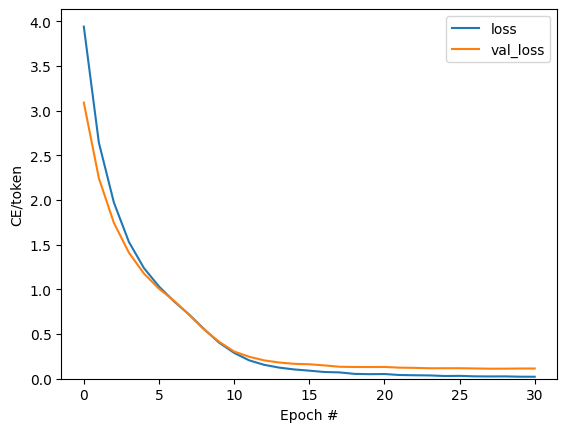

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

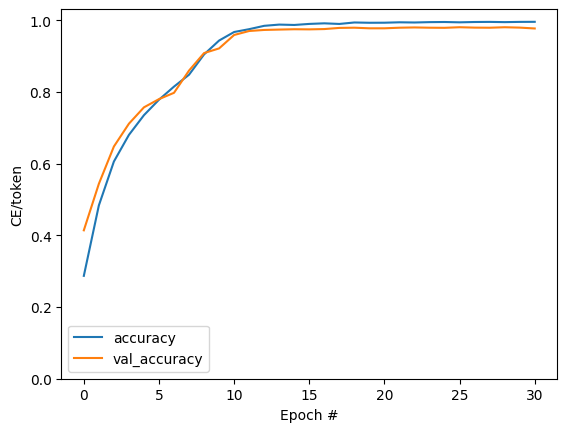

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['ayah akan mandi'])
result[0].numpy().decode()

'baba na sou '

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

<ipython-input-55-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-55-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


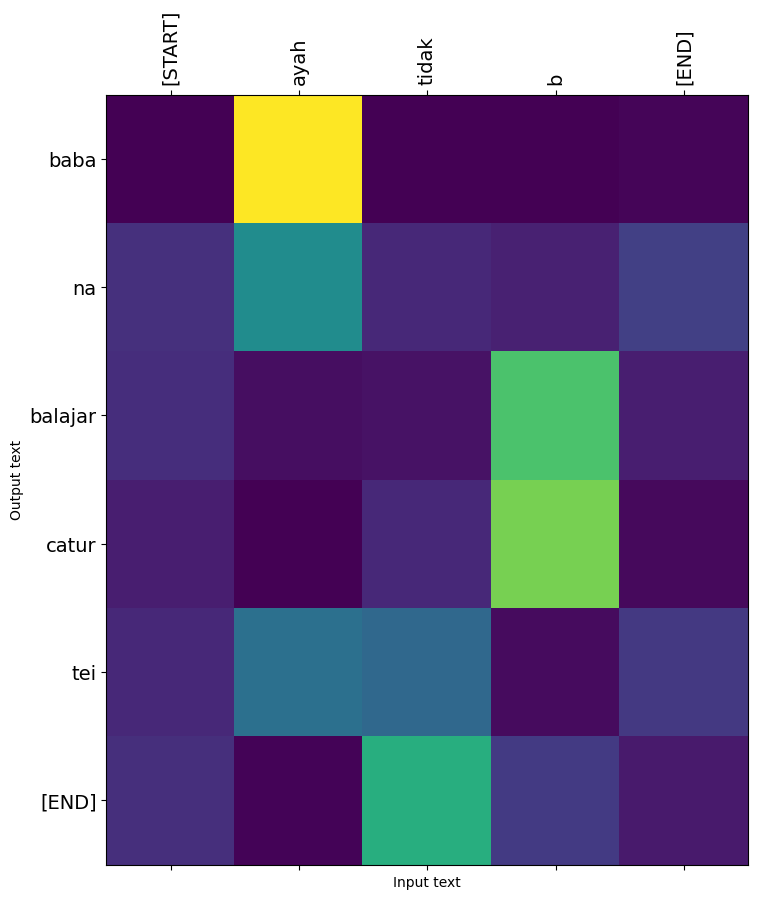

In [ ]:
model.plot_attention('ayah tidak b')

In [ ]:
%%time
result = model.translate(tf.constant(context_test))

terjemahan = []
for i in range(len(result)):
    hsl = result[i].numpy().decode()
    terjemahan.append(hsl)

CPU times: user 1.62 s, sys: 75.7 ms, total: 1.69 s
Wall time: 1.75 s


In [ ]:

df = pd.DataFrame({"Terjemahan": terjemahan})
df.to_csv("terjemahan.csv", index=False)

In [ ]:
len (hsl)

19

In [ ]:
asli = target_test

In [ ]:
indo = context_test

In [ ]:

dc = pd.DataFrame({"ind": indo})
dc.to_csv("indo.csv", index=False)


In [ ]:
dx = pd.DataFrame({"asli": asli})
dx.to_csv("asli.csv", index=False)

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

In [ ]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 57s, sys: 3.28 s, total: 2min
Wall time: 2min 12s


In [ ]:
loaded = tf.saved_model.load('/content/dynamic_translator', options=tf.saved_model.LoadOptions(experimental_io_device='/job:localhost'))
translate_func = loaded.signatures['serving_default']

In [ ]:
# Create the converter
converter = tf.lite.TFLiteConverter.from_saved_model('/content/dynamic_translator')

In [ ]:
# Set the target specification
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Convert the model
tflite_model = converter.convert()

In [ ]:
# Save the converted model to a file
with open("model_terbaru.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
!cp /content/model_terbaru.tflite /content/drive/My\ Drive